# CartPole - vanilla DQN
- 어쩌다가 한 번 학습은 잘 되는데 확률이 너무 낮음
- 애초에 불안정한 알고리즘이라 그렇다고는 하는데 breakout까지 잘 하는 거 보면 내가 못해서 그런 거 같음
- 네트워크 구조는 학습이 한 번 성공하면 바꾸지 말라고 함
- 검색해보니 여러 가지 조작해보는 걸 추천함
    - $\gamma=1$로 바꾸기
    - Gradient clipping
    - $\varepsilon > 0.1$
    - Replay memory 사이즈 늘리기
    - Soft update (몇 스텝마다 한 번씩 업데이트... 맞나?)
- 발산하는 경우 몇 개의 weight의 gradient가 매우 큰 것을 확인함.
    - **이런 애들만 리셋시키고 학습시키는 방법도 괜찮을 거 같음**
- `clip_grad_norm_`은 `arg`로 들어온 weight들을 하나의 벡터로 보고 clip 해주는 거임. 정확한 동작은 실험 몇 번 해봐야 될 듯

## 내가 알아낸 휴리스틱이 몇 가지 있음
- 네트워크 마지막 단에 `LeakyReLU(.5)` 사용
    - Gradient가 발산하는 모양새가 비선형성이 부족해서 그런 거 같아서 마지막에 비선형 함수 하나 넣어줬더니 뭔가 더 잘 학습됐음. 기분 탓이 아님.
- reward는 극단적이면 학습이 더 불안정해짐. 최대한 자주, 절댓값이 작은 값들 위주로 줘야 함.
- `batch_size` 키워도 좋아짐

In [1]:
import gym
import gym_Aircraft

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# env = gym.make("acav-v0")
env = gym.make("CartPole-v1")
# env.action_space.seed(960501) 

In [3]:
dim_obs = env.observation_space.shape[0]
dim_act = env.action_space.n
max_episode = 5000
max_replay = 10000
batch_size = 256 
gamma = .9  # ㅋㅋㅋ .9에서 1로 바꾸니까 갑자기 잘됨
eps = 1.  # 얘도 1로 시작해야 되네
eps_decay = .99
eps_decay_step = 10
learning_rate = 1e-6  # 학습하다가 발산하면 얘부터 만져봐야 됨
max_grad_norm = 10

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim_obs, 128),
            nn.ReLU(),
            nn.Linear(128, dim_act),
            nn.LeakyReLU(.5),  # 와 이거 혁신이네
        )
        
    def forward(self, *input):
        return self.model(*input).squeeze()

In [5]:
net = DQN().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

memory = []
record = {'score': [], 'average loss': []}
max_memory = 5000

global_step = 0
train_step = 0
for episode in range(max_episode):
    s0 = env.reset()
    done = False
    net_reward = 0
    episode_loss = 0
    episode_norm = 0
    episode_step = 0
    
    while not done:
        if train_step % eps_decay_step == eps_decay_step - 1:
            eps *= eps_decay
            eps = max(.001, eps)
            
        if random.random() > eps:
            a = np.argmax(net(torch.from_numpy(s0).float().to(device)).detach().cpu())
            a = int(a) 
        else:
            a = env.action_space.sample()
            
        s1, reward, done, _ = env.step(a)
#         reward = -100 if done else reward
        s0 = s1
        net_reward += reward
        # reward를 episode 내내 매 step마다 주면 어떰?
            # 충돌하면 -100
            # 연료 쓰면 -.1
        
        memory.append([s0, a, reward, s1, done])
        if len(memory) > max_replay:
            del memory[0]
        
        if global_step == max_replay - 1:
            print('Training now begins')
        
# https://stackoverflow.com/questions/52770780/why-is-my-deep-q-net-and-double-deep-q-net-unstable
        if len(memory) == max_replay and global_step % 2 == 0:  # soft update
            y_batch = np.zeros(batch_size)
            s0_batch = np.zeros((batch_size, dim_obs))
            for j, sample in enumerate(random.sample(memory, batch_size)):
                mem_s0, mem_a, mem_reward, mem_s1, is_terminal = sample
                s0_batch[j] = mem_s0
                if is_terminal:
                    y_batch[j] = mem_reward
                else:
                    # y_j = r_j + gamma * max_a' Q(s_j+1, a')
                    y_batch[j] = mem_reward + gamma * torch.max(net(torch.from_numpy(mem_s1).float().to(device)).detach()).cpu().numpy()
            # optimize Q w.r.t ||max_a Q(s, a) - y||
            loss = criterion(
                torch.max(net(torch.from_numpy(s0_batch).float().to(device)), 1)[0],
                torch.from_numpy(y_batch).float().to(device)
            )
            loss.backward()
            episode_norm += torch_utils.clip_grad_norm_(net.parameters(), max_grad_norm)
            optimizer.step()
            train_step += 1
            episode_loss += loss
        episode_step += 1
        global_step += 1
    
    # episode log
    print(f'Episode {episode+1:4d}  score: {net_reward:3.0f}', end='  ')
    if len(memory) == max_replay:
        average_episode_loss = episode_loss/episode_step
        record['score'].append(net_reward)
        record['average loss'].append(average_episode_loss)
        print(
            f'Average Episode Loss: {average_episode_loss:5.3f}  '
            f'e: {eps:.4f}  norm: {episode_norm/episode_step:6.3f}')
    else:
        print()

Episode    1  score:  53  
Episode    2  score:  42  
Episode    3  score:  18  
Episode    4  score:  38  
Episode    5  score:  24  
Episode    6  score:  13  
Episode    7  score:  20  
Episode    8  score:  25  
Episode    9  score:  29  
Episode   10  score:  18  
Episode   11  score:   9  
Episode   12  score:  25  
Episode   13  score:  14  
Episode   14  score:  45  
Episode   15  score:  43  
Episode   16  score:  43  
Episode   17  score:  32  
Episode   18  score:  34  
Episode   19  score:  24  
Episode   20  score:  17  
Episode   21  score:  17  
Episode   22  score:  34  
Episode   23  score:  17  
Episode   24  score:  23  
Episode   25  score:  89  
Episode   26  score:  27  
Episode   27  score:  25  
Episode   28  score:  22  
Episode   29  score:  25  
Episode   30  score:  12  
Episode   31  score:  26  
Episode   32  score:  17  
Episode   33  score:  13  
Episode   34  score:  15  
Episode   35  score:  20  
Episode   36  score:  13  
Episode   37  score:  12  
E

Episode  446  score:  49  Average Episode Loss: 0.144  e: 1.0000  norm:  1.157
Episode  447  score:  19  Average Episode Loss: 0.477  e: 0.9801  norm:  5.764
Episode  448  score:  14  Average Episode Loss: 0.503  e: 0.9606  norm:  6.076
Episode  449  score:  12  Average Episode Loss: 0.504  e: 0.9510  norm:  6.080
Episode  450  score:  15  Average Episode Loss: 0.537  e: 0.9415  norm:  6.476
Episode  451  score:  12  Average Episode Loss: 0.504  e: 0.9227  norm:  6.088
Episode  452  score:  34  Average Episode Loss: 0.503  e: 0.8864  norm:  6.087
Episode  453  score:  29  Average Episode Loss: 0.486  e: 0.8687  norm:  5.869
Episode  454  score:  51  Average Episode Loss: 0.513  e: 0.8179  norm:  6.219
Episode  455  score:  37  Average Episode Loss: 0.489  e: 0.8016  norm:  5.923
Episode  456  score:  56  Average Episode Loss: 0.503  e: 0.7547  norm:  6.099
Episode  457  score:  20  Average Episode Loss: 0.503  e: 0.7397  norm:  6.099
Episode  458  score:  99  Average Episode Loss: 0.50

Episode  550  score:  61  Average Episode Loss: 0.493  e: 0.0010  norm:  7.602
Episode  551  score:  65  Average Episode Loss: 0.478  e: 0.0010  norm:  7.351
Episode  552  score:  48  Average Episode Loss: 0.485  e: 0.0010  norm:  7.469
Episode  553  score:  64  Average Episode Loss: 0.485  e: 0.0010  norm:  7.471
Episode  554  score:  60  Average Episode Loss: 0.485  e: 0.0010  norm:  7.475
Episode  555  score:  56  Average Episode Loss: 0.485  e: 0.0010  norm:  7.457
Episode  556  score:  66  Average Episode Loss: 0.485  e: 0.0010  norm:  7.465
Episode  557  score:  50  Average Episode Loss: 0.485  e: 0.0010  norm:  7.479
Episode  558  score:  52  Average Episode Loss: 0.484  e: 0.0010  norm:  7.473
Episode  559  score:  64  Average Episode Loss: 0.485  e: 0.0010  norm:  7.472
Episode  560  score:  52  Average Episode Loss: 0.484  e: 0.0010  norm:  7.469
Episode  561  score:  50  Average Episode Loss: 0.485  e: 0.0010  norm:  7.439
Episode  562  score:  49  Average Episode Loss: 0.49

Episode  654  score:  84  Average Episode Loss: 0.480  e: 0.0010  norm:  7.095
Episode  655  score:  81  Average Episode Loss: 0.474  e: 0.0010  norm:  7.045
Episode  656  score:  83  Average Episode Loss: 0.485  e: 0.0010  norm:  7.243
Episode  657  score:  88  Average Episode Loss: 0.479  e: 0.0010  norm:  7.181
Episode  658  score: 107  Average Episode Loss: 0.475  e: 0.0010  norm:  7.167
Episode  659  score: 100  Average Episode Loss: 0.479  e: 0.0010  norm:  7.272
Episode  660  score: 110  Average Episode Loss: 0.479  e: 0.0010  norm:  7.312
Episode  661  score:  90  Average Episode Loss: 0.479  e: 0.0010  norm:  7.361
Episode  662  score:  92  Average Episode Loss: 0.479  e: 0.0010  norm:  7.406
Episode  663  score: 102  Average Episode Loss: 0.478  e: 0.0010  norm:  7.453
Episode  664  score: 107  Average Episode Loss: 0.483  e: 0.0010  norm:  7.567
Episode  665  score: 135  Average Episode Loss: 0.474  e: 0.0010  norm:  7.488
Episode  666  score: 116  Average Episode Loss: 0.47

Episode  758  score:  70  Average Episode Loss: 0.479  e: 0.0010  norm:  6.667
Episode  759  score:  64  Average Episode Loss: 0.479  e: 0.0010  norm:  6.668
Episode  760  score:  65  Average Episode Loss: 0.486  e: 0.0010  norm:  6.766
Episode  761  score:  73  Average Episode Loss: 0.472  e: 0.0010  norm:  6.560
Episode  762  score:  76  Average Episode Loss: 0.478  e: 0.0010  norm:  6.649
Episode  763  score: 148  Average Episode Loss: 0.478  e: 0.0010  norm:  6.643
Episode  764  score:  73  Average Episode Loss: 0.485  e: 0.0010  norm:  6.730
Episode  765  score:  82  Average Episode Loss: 0.479  e: 0.0010  norm:  6.641
Episode  766  score:  75  Average Episode Loss: 0.472  e: 0.0010  norm:  6.549
Episode  767  score:  60  Average Episode Loss: 0.478  e: 0.0010  norm:  6.638
Episode  768  score: 153  Average Episode Loss: 0.482  e: 0.0010  norm:  6.681
Episode  769  score:  74  Average Episode Loss: 0.479  e: 0.0010  norm:  6.637
Episode  770  score:  70  Average Episode Loss: 0.47

Episode  862  score: 101  Average Episode Loss: 0.459  e: 0.0010  norm:  7.050
Episode  863  score: 105  Average Episode Loss: 0.450  e: 0.0010  norm:  6.919
Episode  864  score: 122  Average Episode Loss: 0.454  e: 0.0010  norm:  6.992
Episode  865  score: 127  Average Episode Loss: 0.457  e: 0.0010  norm:  7.053
Episode  866  score: 127  Average Episode Loss: 0.449  e: 0.0010  norm:  6.950
Episode  867  score: 144  Average Episode Loss: 0.452  e: 0.0010  norm:  7.036
Episode  868  score: 160  Average Episode Loss: 0.452  e: 0.0010  norm:  7.052
Episode  869  score: 154  Average Episode Loss: 0.451  e: 0.0010  norm:  7.090
Episode  870  score: 188  Average Episode Loss: 0.450  e: 0.0010  norm:  7.151
Episode  871  score: 161  Average Episode Loss: 0.452  e: 0.0010  norm:  7.257
Episode  872  score: 208  Average Episode Loss: 0.448  e: 0.0010  norm:  7.274
Episode  873  score: 263  Average Episode Loss: 0.446  e: 0.0010  norm:  7.356
Episode  874  score: 248  Average Episode Loss: 0.44

Episode  966  score:  73  Average Episode Loss: 0.463  e: 0.0010  norm:  6.739
Episode  967  score:  67  Average Episode Loss: 0.450  e: 0.0010  norm:  6.547
Episode  968  score:  69  Average Episode Loss: 0.464  e: 0.0010  norm:  6.730
Episode  969  score: 155  Average Episode Loss: 0.454  e: 0.0010  norm:  6.586
Episode  970  score: 151  Average Episode Loss: 0.460  e: 0.0010  norm:  6.671
Episode  971  score:  60  Average Episode Loss: 0.457  e: 0.0010  norm:  6.620
Episode  972  score: 161  Average Episode Loss: 0.454  e: 0.0010  norm:  6.567
Episode  973  score:  72  Average Episode Loss: 0.457  e: 0.0010  norm:  6.611
Episode  974  score: 155  Average Episode Loss: 0.460  e: 0.0010  norm:  6.650
Episode  975  score: 152  Average Episode Loss: 0.457  e: 0.0010  norm:  6.603
Episode  976  score: 163  Average Episode Loss: 0.455  e: 0.0010  norm:  6.564
Episode  977  score: 240  Average Episode Loss: 0.458  e: 0.0010  norm:  6.613
Episode  978  score: 165  Average Episode Loss: 0.46

Episode 1070  score:  62  Average Episode Loss: 0.433  e: 0.0010  norm:  6.785
Episode 1071  score:  78  Average Episode Loss: 0.434  e: 0.0010  norm:  6.783
Episode 1072  score:  75  Average Episode Loss: 0.428  e: 0.0010  norm:  6.669
Episode 1073  score: 147  Average Episode Loss: 0.437  e: 0.0010  norm:  6.792
Episode 1074  score: 185  Average Episode Loss: 0.432  e: 0.0010  norm:  6.691
Episode 1075  score:  81  Average Episode Loss: 0.441  e: 0.0010  norm:  6.792
Episode 1076  score: 178  Average Episode Loss: 0.435  e: 0.0010  norm:  6.695
Episode 1077  score: 185  Average Episode Loss: 0.434  e: 0.0010  norm:  6.643
Episode 1078  score:  75  Average Episode Loss: 0.441  e: 0.0010  norm:  6.756
Episode 1079  score:  82  Average Episode Loss: 0.437  e: 0.0010  norm:  6.661
Episode 1080  score: 167  Average Episode Loss: 0.433  e: 0.0010  norm:  6.608
Episode 1081  score: 153  Average Episode Loss: 0.440  e: 0.0010  norm:  6.682
Episode 1082  score:  85  Average Episode Loss: 0.43

Episode 1174  score: 500  Average Episode Loss: 0.408  e: 0.0010  norm:  6.669
Episode 1175  score: 299  Average Episode Loss: 0.409  e: 0.0010  norm:  6.696
Episode 1176  score: 383  Average Episode Loss: 0.406  e: 0.0010  norm:  6.660
Episode 1177  score: 475  Average Episode Loss: 0.407  e: 0.0010  norm:  6.694
Episode 1178  score: 249  Average Episode Loss: 0.404  e: 0.0010  norm:  6.661
Episode 1179  score: 377  Average Episode Loss: 0.406  e: 0.0010  norm:  6.706
Episode 1180  score: 317  Average Episode Loss: 0.403  e: 0.0010  norm:  6.672
Episode 1181  score: 300  Average Episode Loss: 0.404  e: 0.0010  norm:  6.695
Episode 1182  score: 302  Average Episode Loss: 0.403  e: 0.0010  norm:  6.698
Episode 1183  score: 289  Average Episode Loss: 0.404  e: 0.0010  norm:  6.722
Episode 1184  score: 298  Average Episode Loss: 0.401  e: 0.0010  norm:  6.706
Episode 1185  score: 400  Average Episode Loss: 0.401  e: 0.0010  norm:  6.701
Episode 1186  score: 265  Average Episode Loss: 0.39

Episode 1278  score: 136  Average Episode Loss: 0.368  e: 0.0010  norm:  6.693
Episode 1279  score: 191  Average Episode Loss: 0.369  e: 0.0010  norm:  6.731
Episode 1280  score: 322  Average Episode Loss: 0.369  e: 0.0010  norm:  6.685
Episode 1281  score: 248  Average Episode Loss: 0.369  e: 0.0010  norm:  6.688
Episode 1282  score: 181  Average Episode Loss: 0.366  e: 0.0010  norm:  6.653
Episode 1283  score: 210  Average Episode Loss: 0.368  e: 0.0010  norm:  6.686
Episode 1284  score: 204  Average Episode Loss: 0.367  e: 0.0010  norm:  6.696
Episode 1285  score: 181  Average Episode Loss: 0.370  e: 0.0010  norm:  6.727
Episode 1286  score: 151  Average Episode Loss: 0.365  e: 0.0010  norm:  6.656
Episode 1287  score: 116  Average Episode Loss: 0.370  e: 0.0010  norm:  6.689
Episode 1288  score: 214  Average Episode Loss: 0.368  e: 0.0010  norm:  6.690
Episode 1289  score: 169  Average Episode Loss: 0.373  e: 0.0010  norm:  6.724
Episode 1290  score: 147  Average Episode Loss: 0.36

Episode 1382  score: 179  Average Episode Loss: 0.350  e: 0.0010  norm:  6.639
Episode 1383  score: 159  Average Episode Loss: 0.355  e: 0.0010  norm:  6.718
Episode 1384  score: 154  Average Episode Loss: 0.353  e: 0.0010  norm:  6.670
Episode 1385  score: 140  Average Episode Loss: 0.353  e: 0.0010  norm:  6.677
Episode 1386  score: 184  Average Episode Loss: 0.354  e: 0.0010  norm:  6.683
Episode 1387  score: 106  Average Episode Loss: 0.354  e: 0.0010  norm:  6.676
Episode 1388  score: 147  Average Episode Loss: 0.351  e: 0.0010  norm:  6.636
Episode 1389  score: 154  Average Episode Loss: 0.354  e: 0.0010  norm:  6.682
Episode 1390  score: 160  Average Episode Loss: 0.352  e: 0.0010  norm:  6.684
Episode 1391  score: 136  Average Episode Loss: 0.353  e: 0.0010  norm:  6.681
Episode 1392  score: 200  Average Episode Loss: 0.353  e: 0.0010  norm:  6.679
Episode 1393  score: 165  Average Episode Loss: 0.355  e: 0.0010  norm:  6.722
Episode 1394  score: 194  Average Episode Loss: 0.35

Episode 1486  score: 153  Average Episode Loss: 0.337  e: 0.0010  norm:  6.713
Episode 1487  score: 170  Average Episode Loss: 0.337  e: 0.0010  norm:  6.661
Episode 1488  score: 183  Average Episode Loss: 0.334  e: 0.0010  norm:  6.623
Episode 1489  score: 141  Average Episode Loss: 0.339  e: 0.0010  norm:  6.702
Episode 1490  score: 139  Average Episode Loss: 0.332  e: 0.0010  norm:  6.619
Episode 1491  score: 147  Average Episode Loss: 0.337  e: 0.0010  norm:  6.709
Episode 1492  score: 149  Average Episode Loss: 0.333  e: 0.0010  norm:  6.619
Episode 1493  score: 190  Average Episode Loss: 0.335  e: 0.0010  norm:  6.661
Episode 1494  score: 169  Average Episode Loss: 0.336  e: 0.0010  norm:  6.699
Episode 1495  score: 142  Average Episode Loss: 0.334  e: 0.0010  norm:  6.660
Episode 1496  score: 140  Average Episode Loss: 0.333  e: 0.0010  norm:  6.664
Episode 1497  score: 148  Average Episode Loss: 0.334  e: 0.0010  norm:  6.661
Episode 1498  score: 154  Average Episode Loss: 0.33

Episode 1590  score: 114  Average Episode Loss: 0.319  e: 0.0010  norm:  6.701
Episode 1591  score: 128  Average Episode Loss: 0.322  e: 0.0010  norm:  6.692
Episode 1592  score: 139  Average Episode Loss: 0.319  e: 0.0010  norm:  6.655
Episode 1593  score: 169  Average Episode Loss: 0.323  e: 0.0010  norm:  6.749
Episode 1594  score: 185  Average Episode Loss: 0.318  e: 0.0010  norm:  6.685
Episode 1595  score: 122  Average Episode Loss: 0.319  e: 0.0010  norm:  6.717
Episode 1596  score: 500  Average Episode Loss: 0.320  e: 0.0010  norm:  6.708
Episode 1597  score: 156  Average Episode Loss: 0.320  e: 0.0010  norm:  6.693
Episode 1598  score: 139  Average Episode Loss: 0.322  e: 0.0010  norm:  6.743
Episode 1599  score: 118  Average Episode Loss: 0.320  e: 0.0010  norm:  6.690
Episode 1600  score: 125  Average Episode Loss: 0.316  e: 0.0010  norm:  6.642
Episode 1601  score: 121  Average Episode Loss: 0.319  e: 0.0010  norm:  6.762
Episode 1602  score: 149  Average Episode Loss: 0.31

Episode 1694  score: 121  Average Episode Loss: 0.298  e: 0.0010  norm:  6.629
Episode 1695  score: 112  Average Episode Loss: 0.304  e: 0.0010  norm:  6.673
Episode 1696  score: 123  Average Episode Loss: 0.307  e: 0.0010  norm:  6.722
Episode 1697  score: 175  Average Episode Loss: 0.301  e: 0.0010  norm:  6.641
Episode 1698  score: 129  Average Episode Loss: 0.305  e: 0.0010  norm:  6.737
Episode 1699  score: 142  Average Episode Loss: 0.301  e: 0.0010  norm:  6.696
Episode 1700  score: 152  Average Episode Loss: 0.302  e: 0.0010  norm:  6.692
Episode 1701  score: 168  Average Episode Loss: 0.300  e: 0.0010  norm:  6.698
Episode 1702  score: 163  Average Episode Loss: 0.299  e: 0.0010  norm:  6.653
Episode 1703  score: 130  Average Episode Loss: 0.299  e: 0.0010  norm:  6.697
Episode 1704  score: 163  Average Episode Loss: 0.301  e: 0.0010  norm:  6.740
Episode 1705  score: 205  Average Episode Loss: 0.302  e: 0.0010  norm:  6.647
Episode 1706  score: 184  Average Episode Loss: 0.30

Episode 1798  score: 146  Average Episode Loss: 0.290  e: 0.0010  norm:  6.675
Episode 1799  score: 147  Average Episode Loss: 0.287  e: 0.0010  norm:  6.632
Episode 1800  score: 116  Average Episode Loss: 0.288  e: 0.0010  norm:  6.675
Episode 1801  score: 500  Average Episode Loss: 0.292  e: 0.0010  norm:  6.660
Episode 1802  score: 117  Average Episode Loss: 0.292  e: 0.0010  norm:  6.720
Episode 1803  score: 121  Average Episode Loss: 0.290  e: 0.0010  norm:  6.597
Episode 1804  score: 179  Average Episode Loss: 0.289  e: 0.0010  norm:  6.702
Episode 1805  score: 500  Average Episode Loss: 0.289  e: 0.0010  norm:  6.649
Episode 1806  score: 145  Average Episode Loss: 0.287  e: 0.0010  norm:  6.593
Episode 1807  score: 219  Average Episode Loss: 0.289  e: 0.0010  norm:  6.671
Episode 1808  score: 140  Average Episode Loss: 0.290  e: 0.0010  norm:  6.634
Episode 1809  score: 214  Average Episode Loss: 0.289  e: 0.0010  norm:  6.630
Episode 1810  score: 124  Average Episode Loss: 0.28

Episode 1902  score: 124  Average Episode Loss: 0.276  e: 0.0010  norm:  6.608
Episode 1903  score: 149  Average Episode Loss: 0.278  e: 0.0010  norm:  6.652
Episode 1904  score: 125  Average Episode Loss: 0.272  e: 0.0010  norm:  6.561
Episode 1905  score: 123  Average Episode Loss: 0.281  e: 0.0010  norm:  6.656
Episode 1906  score: 134  Average Episode Loss: 0.271  e: 0.0010  norm:  6.621
Episode 1907  score: 182  Average Episode Loss: 0.278  e: 0.0010  norm:  6.603
Episode 1908  score: 167  Average Episode Loss: 0.273  e: 0.0010  norm:  6.570
Episode 1909  score: 500  Average Episode Loss: 0.276  e: 0.0010  norm:  6.601
Episode 1910  score: 126  Average Episode Loss: 0.272  e: 0.0010  norm:  6.608
Episode 1911  score: 131  Average Episode Loss: 0.273  e: 0.0010  norm:  6.664
Episode 1912  score: 129  Average Episode Loss: 0.271  e: 0.0010  norm:  6.560
Episode 1913  score: 158  Average Episode Loss: 0.276  e: 0.0010  norm:  6.603
Episode 1914  score: 135  Average Episode Loss: 0.27

Episode 2006  score: 172  Average Episode Loss: 0.266  e: 0.0010  norm:  6.602
Episode 2007  score: 126  Average Episode Loss: 0.266  e: 0.0010  norm:  6.599
Episode 2008  score: 158  Average Episode Loss: 0.272  e: 0.0010  norm:  6.587
Episode 2009  score: 154  Average Episode Loss: 0.266  e: 0.0010  norm:  6.598
Episode 2010  score: 119  Average Episode Loss: 0.270  e: 0.0010  norm:  6.649
Episode 2011  score: 128  Average Episode Loss: 0.272  e: 0.0010  norm:  6.585
Episode 2012  score: 116  Average Episode Loss: 0.261  e: 0.0010  norm:  6.609
Episode 2013  score: 123  Average Episode Loss: 0.265  e: 0.0010  norm:  6.543
Episode 2014  score: 122  Average Episode Loss: 0.268  e: 0.0010  norm:  6.595
Episode 2015  score: 167  Average Episode Loss: 0.267  e: 0.0010  norm:  6.641
Episode 2016  score: 151  Average Episode Loss: 0.265  e: 0.0010  norm:  6.551
Episode 2017  score: 138  Average Episode Loss: 0.268  e: 0.0010  norm:  6.593
Episode 2018  score: 155  Average Episode Loss: 0.26

Episode 2110  score: 146  Average Episode Loss: 0.267  e: 0.0010  norm:  6.529
Episode 2111  score: 144  Average Episode Loss: 0.268  e: 0.0010  norm:  6.528
Episode 2112  score: 131  Average Episode Loss: 0.265  e: 0.0010  norm:  6.480
Episode 2113  score: 162  Average Episode Loss: 0.265  e: 0.0010  norm:  6.530
Episode 2114  score: 156  Average Episode Loss: 0.267  e: 0.0010  norm:  6.527
Episode 2115  score: 141  Average Episode Loss: 0.267  e: 0.0010  norm:  6.575
Episode 2116  score: 122  Average Episode Loss: 0.271  e: 0.0010  norm:  6.517
Episode 2117  score: 212  Average Episode Loss: 0.264  e: 0.0010  norm:  6.528
Episode 2118  score: 201  Average Episode Loss: 0.262  e: 0.0010  norm:  6.496
Episode 2119  score: 221  Average Episode Loss: 0.263  e: 0.0010  norm:  6.556
Episode 2120  score: 144  Average Episode Loss: 0.264  e: 0.0010  norm:  6.524
Episode 2121  score: 143  Average Episode Loss: 0.263  e: 0.0010  norm:  6.475
Episode 2122  score: 126  Average Episode Loss: 0.26

Episode 2214  score: 217  Average Episode Loss: 0.253  e: 0.0010  norm:  6.440
Episode 2215  score: 143  Average Episode Loss: 0.273  e: 0.0010  norm:  6.487
Episode 2216  score: 117  Average Episode Loss: 0.256  e: 0.0010  norm:  6.407
Episode 2217  score: 123  Average Episode Loss: 0.257  e: 0.0010  norm:  6.518
Episode 2218  score: 115  Average Episode Loss: 0.258  e: 0.0010  norm:  6.401
Episode 2219  score: 208  Average Episode Loss: 0.264  e: 0.0010  norm:  6.448
Episode 2220  score: 134  Average Episode Loss: 0.264  e: 0.0010  norm:  6.445
Episode 2221  score: 161  Average Episode Loss: 0.247  e: 0.0010  norm:  6.517
Episode 2222  score: 125  Average Episode Loss: 0.262  e: 0.0010  norm:  6.392
Episode 2223  score: 143  Average Episode Loss: 0.255  e: 0.0010  norm:  6.508
Episode 2224  score: 123  Average Episode Loss: 0.233  e: 0.0010  norm:  6.438
Episode 2225  score: 144  Average Episode Loss: 0.255  e: 0.0010  norm:  6.460
Episode 2226  score: 116  Average Episode Loss: 0.25

Episode 2318  score: 151  Average Episode Loss: 0.277  e: 0.0010  norm:  6.307
Episode 2319  score: 154  Average Episode Loss: 0.251  e: 0.0010  norm:  6.391
Episode 2320  score: 204  Average Episode Loss: 0.272  e: 0.0010  norm:  6.358
Episode 2321  score: 120  Average Episode Loss: 0.271  e: 0.0010  norm:  6.361
Episode 2322  score: 137  Average Episode Loss: 0.280  e: 0.0010  norm:  6.393
Episode 2323  score: 156  Average Episode Loss: 0.259  e: 0.0010  norm:  6.373
Episode 2324  score: 154  Average Episode Loss: 0.270  e: 0.0010  norm:  6.357
Episode 2325  score: 118  Average Episode Loss: 0.290  e: 0.0010  norm:  6.326
Episode 2326  score: 201  Average Episode Loss: 0.283  e: 0.0010  norm:  6.303
Episode 2327  score: 156  Average Episode Loss: 0.266  e: 0.0010  norm:  6.361
Episode 2328  score: 161  Average Episode Loss: 0.276  e: 0.0010  norm:  6.388
Episode 2329  score: 131  Average Episode Loss: 0.249  e: 0.0010  norm:  6.333
Episode 2330  score: 140  Average Episode Loss: 0.26

Episode 2422  score: 124  Average Episode Loss: 0.252  e: 0.0010  norm:  6.274
Episode 2423  score: 145  Average Episode Loss: 0.269  e: 0.0010  norm:  6.305
Episode 2424  score: 162  Average Episode Loss: 0.242  e: 0.0010  norm:  6.287
Episode 2425  score: 127  Average Episode Loss: 0.276  e: 0.0010  norm:  6.200
Episode 2426  score: 247  Average Episode Loss: 0.276  e: 0.0010  norm:  6.272
Episode 2427  score: 129  Average Episode Loss: 0.247  e: 0.0010  norm:  6.230
Episode 2428  score: 162  Average Episode Loss: 0.280  e: 0.0010  norm:  6.240
Episode 2429  score: 134  Average Episode Loss: 0.265  e: 0.0010  norm:  6.254
Episode 2430  score: 131  Average Episode Loss: 0.270  e: 0.0010  norm:  6.303
Episode 2431  score: 145  Average Episode Loss: 0.289  e: 0.0010  norm:  6.178
Episode 2432  score: 121  Average Episode Loss: 0.254  e: 0.0010  norm:  6.325
Episode 2433  score: 126  Average Episode Loss: 0.264  e: 0.0010  norm:  6.258
Episode 2434  score: 194  Average Episode Loss: 0.25

Episode 2526  score: 164  Average Episode Loss: 0.277  e: 0.0010  norm:  6.171
Episode 2527  score: 165  Average Episode Loss: 0.270  e: 0.0010  norm:  6.213
Episode 2528  score: 159  Average Episode Loss: 0.274  e: 0.0010  norm:  6.138
Episode 2529  score: 131  Average Episode Loss: 0.258  e: 0.0010  norm:  6.243
Episode 2530  score: 188  Average Episode Loss: 0.260  e: 0.0010  norm:  6.182
Episode 2531  score: 132  Average Episode Loss: 0.275  e: 0.0010  norm:  6.173
Episode 2532  score: 168  Average Episode Loss: 0.268  e: 0.0010  norm:  6.176
Episode 2533  score: 130  Average Episode Loss: 0.245  e: 0.0010  norm:  6.192
Episode 2534  score: 157  Average Episode Loss: 0.248  e: 0.0010  norm:  6.148
Episode 2535  score: 233  Average Episode Loss: 0.259  e: 0.0010  norm:  6.209
Episode 2536  score: 230  Average Episode Loss: 0.276  e: 0.0010  norm:  6.164
Episode 2537  score: 226  Average Episode Loss: 0.245  e: 0.0010  norm:  6.196
Episode 2538  score: 151  Average Episode Loss: 0.26

Episode 2630  score: 158  Average Episode Loss: 0.272  e: 0.0010  norm:  6.064
Episode 2631  score: 152  Average Episode Loss: 0.250  e: 0.0010  norm:  6.087
Episode 2632  score: 165  Average Episode Loss: 0.293  e: 0.0010  norm:  6.080
Episode 2633  score: 247  Average Episode Loss: 0.269  e: 0.0010  norm:  6.046
Episode 2634  score: 256  Average Episode Loss: 0.257  e: 0.0010  norm:  6.084
Episode 2635  score: 155  Average Episode Loss: 0.285  e: 0.0010  norm:  6.106
Episode 2636  score: 151  Average Episode Loss: 0.248  e: 0.0010  norm:  6.052
Episode 2637  score: 165  Average Episode Loss: 0.246  e: 0.0010  norm:  6.131
Episode 2638  score: 133  Average Episode Loss: 0.286  e: 0.0010  norm:  6.014
Episode 2639  score: 133  Average Episode Loss: 0.251  e: 0.0010  norm:  6.141
Episode 2640  score: 454  Average Episode Loss: 0.260  e: 0.0010  norm:  6.083
Episode 2641  score: 120  Average Episode Loss: 0.270  e: 0.0010  norm:  6.082
Episode 2642  score: 188  Average Episode Loss: 0.26

Episode 2734  score: 142  Average Episode Loss: 0.241  e: 0.0010  norm:  6.031
Episode 2735  score: 159  Average Episode Loss: 0.227  e: 0.0010  norm:  6.003
Episode 2736  score: 142  Average Episode Loss: 0.234  e: 0.0010  norm:  6.031
Episode 2737  score: 123  Average Episode Loss: 0.215  e: 0.0010  norm:  6.098
Episode 2738  score: 142  Average Episode Loss: 0.262  e: 0.0010  norm:  6.000
Episode 2739  score: 119  Average Episode Loss: 0.226  e: 0.0010  norm:  5.982
Episode 2740  score: 118  Average Episode Loss: 0.248  e: 0.0010  norm:  6.009
Episode 2741  score: 177  Average Episode Loss: 0.256  e: 0.0010  norm:  6.039
Episode 2742  score: 155  Average Episode Loss: 0.262  e: 0.0010  norm:  5.959
Episode 2743  score: 161  Average Episode Loss: 0.272  e: 0.0010  norm:  6.019
Episode 2744  score: 171  Average Episode Loss: 0.232  e: 0.0010  norm:  5.978
Episode 2745  score: 151  Average Episode Loss: 0.235  e: 0.0010  norm:  6.068
Episode 2746  score: 146  Average Episode Loss: 0.25

Episode 2838  score: 141  Average Episode Loss: 0.233  e: 0.0010  norm:  5.943
Episode 2839  score: 149  Average Episode Loss: 0.240  e: 0.0010  norm:  6.019
Episode 2840  score: 147  Average Episode Loss: 0.238  e: 0.0010  norm:  5.931
Episode 2841  score: 106  Average Episode Loss: 0.188  e: 0.0010  norm:  6.028
Episode 2842  score: 153  Average Episode Loss: 0.202  e: 0.0010  norm:  6.043
Episode 2843  score: 139  Average Episode Loss: 0.217  e: 0.0010  norm:  5.955
Episode 2844  score: 154  Average Episode Loss: 0.227  e: 0.0010  norm:  5.980
Episode 2845  score: 154  Average Episode Loss: 0.214  e: 0.0010  norm:  5.996
Episode 2846  score: 110  Average Episode Loss: 0.200  e: 0.0010  norm:  6.008
Episode 2847  score: 133  Average Episode Loss: 0.211  e: 0.0010  norm:  6.039
Episode 2848  score: 120  Average Episode Loss: 0.259  e: 0.0010  norm:  5.946
Episode 2849  score:  96  Average Episode Loss: 0.211  e: 0.0010  norm:  5.992
Episode 2850  score: 221  Average Episode Loss: 0.22

Episode 2942  score: 149  Average Episode Loss: 0.229  e: 0.0010  norm:  5.923
Episode 2943  score: 235  Average Episode Loss: 0.238  e: 0.0010  norm:  5.842
Episode 2944  score: 143  Average Episode Loss: 0.251  e: 0.0010  norm:  5.911
Episode 2945  score: 111  Average Episode Loss: 0.233  e: 0.0010  norm:  5.827
Episode 2946  score: 146  Average Episode Loss: 0.214  e: 0.0010  norm:  5.890
Episode 2947  score: 185  Average Episode Loss: 0.248  e: 0.0010  norm:  5.899
Episode 2948  score: 185  Average Episode Loss: 0.193  e: 0.0010  norm:  5.877
Episode 2949  score: 239  Average Episode Loss: 0.223  e: 0.0010  norm:  5.909
Episode 2950  score: 138  Average Episode Loss: 0.222  e: 0.0010  norm:  5.887
Episode 2951  score: 123  Average Episode Loss: 0.222  e: 0.0010  norm:  5.827
Episode 2952  score: 184  Average Episode Loss: 0.221  e: 0.0010  norm:  5.881
Episode 2953  score: 157  Average Episode Loss: 0.231  e: 0.0010  norm:  5.916
Episode 2954  score: 162  Average Episode Loss: 0.23

Episode 3046  score: 269  Average Episode Loss: 0.236  e: 0.0010  norm:  5.786
Episode 3047  score: 173  Average Episode Loss: 0.248  e: 0.0010  norm:  5.723
Episode 3048  score: 118  Average Episode Loss: 0.204  e: 0.0010  norm:  5.793
Episode 3049  score: 171  Average Episode Loss: 0.216  e: 0.0010  norm:  5.814
Episode 3050  score: 227  Average Episode Loss: 0.191  e: 0.0010  norm:  5.780
Episode 3051  score: 107  Average Episode Loss: 0.209  e: 0.0010  norm:  5.849
Episode 3052  score: 159  Average Episode Loss: 0.173  e: 0.0010  norm:  5.786
Episode 3053  score: 191  Average Episode Loss: 0.192  e: 0.0010  norm:  5.836
Episode 3054  score: 112  Average Episode Loss: 0.191  e: 0.0010  norm:  5.815
Episode 3055  score: 123  Average Episode Loss: 0.187  e: 0.0010  norm:  5.769
Episode 3056  score: 216  Average Episode Loss: 0.210  e: 0.0010  norm:  5.794
Episode 3057  score: 166  Average Episode Loss: 0.213  e: 0.0010  norm:  5.795
Episode 3058  score: 139  Average Episode Loss: 0.16

Episode 3150  score: 115  Average Episode Loss: 0.214  e: 0.0010  norm:  5.752
Episode 3151  score: 143  Average Episode Loss: 0.225  e: 0.0010  norm:  5.649
Episode 3152  score: 217  Average Episode Loss: 0.248  e: 0.0010  norm:  5.698
Episode 3153  score: 100  Average Episode Loss: 0.200  e: 0.0010  norm:  5.717
Episode 3154  score: 263  Average Episode Loss: 0.214  e: 0.0010  norm:  5.676
Episode 3155  score: 168  Average Episode Loss: 0.215  e: 0.0010  norm:  5.693
Episode 3156  score: 236  Average Episode Loss: 0.207  e: 0.0010  norm:  5.701
Episode 3157  score: 209  Average Episode Loss: 0.236  e: 0.0010  norm:  5.703
Episode 3158  score: 258  Average Episode Loss: 0.221  e: 0.0010  norm:  5.686
Episode 3159  score:  94  Average Episode Loss: 0.200  e: 0.0010  norm:  5.693
Episode 3160  score: 230  Average Episode Loss: 0.202  e: 0.0010  norm:  5.692
Episode 3161  score: 253  Average Episode Loss: 0.208  e: 0.0010  norm:  5.664
Episode 3162  score: 112  Average Episode Loss: 0.23

Episode 3254  score: 117  Average Episode Loss: 0.182  e: 0.0010  norm:  5.627
Episode 3255  score:  88  Average Episode Loss: 0.155  e: 0.0010  norm:  5.695
Episode 3256  score: 110  Average Episode Loss: 0.189  e: 0.0010  norm:  5.667
Episode 3257  score: 153  Average Episode Loss: 0.200  e: 0.0010  norm:  5.687
Episode 3258  score: 185  Average Episode Loss: 0.197  e: 0.0010  norm:  5.618
Episode 3259  score: 151  Average Episode Loss: 0.200  e: 0.0010  norm:  5.678
Episode 3260  score: 462  Average Episode Loss: 0.195  e: 0.0010  norm:  5.644
Episode 3261  score:  98  Average Episode Loss: 0.172  e: 0.0010  norm:  5.664
Episode 3262  score: 181  Average Episode Loss: 0.179  e: 0.0010  norm:  5.624
Episode 3263  score: 115  Average Episode Loss: 0.189  e: 0.0010  norm:  5.700
Episode 3264  score: 196  Average Episode Loss: 0.176  e: 0.0010  norm:  5.651
Episode 3265  score: 119  Average Episode Loss: 0.173  e: 0.0010  norm:  5.604
Episode 3266  score: 162  Average Episode Loss: 0.20

Episode 3358  score: 137  Average Episode Loss: 0.169  e: 0.0010  norm:  5.616
Episode 3359  score:  76  Average Episode Loss: 0.177  e: 0.0010  norm:  5.567
Episode 3360  score: 177  Average Episode Loss: 0.178  e: 0.0010  norm:  5.537
Episode 3361  score: 163  Average Episode Loss: 0.177  e: 0.0010  norm:  5.604
Episode 3362  score: 139  Average Episode Loss: 0.145  e: 0.0010  norm:  5.560
Episode 3363  score: 115  Average Episode Loss: 0.185  e: 0.0010  norm:  5.615
Episode 3364  score: 206  Average Episode Loss: 0.170  e: 0.0010  norm:  5.574
Episode 3365  score: 188  Average Episode Loss: 0.151  e: 0.0010  norm:  5.592
Episode 3366  score: 122  Average Episode Loss: 0.182  e: 0.0010  norm:  5.559
Episode 3367  score: 105  Average Episode Loss: 0.155  e: 0.0010  norm:  5.529
Episode 3368  score: 111  Average Episode Loss: 0.181  e: 0.0010  norm:  5.608
Episode 3369  score: 223  Average Episode Loss: 0.183  e: 0.0010  norm:  5.531
Episode 3370  score: 109  Average Episode Loss: 0.18

Episode 3462  score: 192  Average Episode Loss: 0.203  e: 0.0010  norm:  5.498
Episode 3463  score: 107  Average Episode Loss: 0.187  e: 0.0010  norm:  5.459
Episode 3464  score: 227  Average Episode Loss: 0.204  e: 0.0010  norm:  5.522
Episode 3465  score: 170  Average Episode Loss: 0.210  e: 0.0010  norm:  5.489
Episode 3466  score: 105  Average Episode Loss: 0.191  e: 0.0010  norm:  5.450
Episode 3467  score: 134  Average Episode Loss: 0.216  e: 0.0010  norm:  5.486
Episode 3468  score: 125  Average Episode Loss: 0.161  e: 0.0010  norm:  5.571
Episode 3469  score: 130  Average Episode Loss: 0.225  e: 0.0010  norm:  5.470
Episode 3470  score: 107  Average Episode Loss: 0.164  e: 0.0010  norm:  5.460
Episode 3471  score:  81  Average Episode Loss: 0.195  e: 0.0010  norm:  5.559
Episode 3472  score: 164  Average Episode Loss: 0.205  e: 0.0010  norm:  5.481
Episode 3473  score: 111  Average Episode Loss: 0.208  e: 0.0010  norm:  5.423
Episode 3474  score: 170  Average Episode Loss: 0.22

Episode 3566  score: 101  Average Episode Loss: 0.221  e: 0.0010  norm:  5.454
Episode 3567  score:  70  Average Episode Loss: 0.195  e: 0.0010  norm:  5.417
Episode 3568  score: 114  Average Episode Loss: 0.242  e: 0.0010  norm:  5.385
Episode 3569  score: 126  Average Episode Loss: 0.180  e: 0.0010  norm:  5.425
Episode 3570  score:  81  Average Episode Loss: 0.221  e: 0.0010  norm:  5.327
Episode 3571  score: 116  Average Episode Loss: 0.185  e: 0.0010  norm:  5.428
Episode 3572  score:  83  Average Episode Loss: 0.264  e: 0.0010  norm:  5.432
Episode 3573  score: 132  Average Episode Loss: 0.204  e: 0.0010  norm:  5.406
Episode 3574  score:  94  Average Episode Loss: 0.171  e: 0.0010  norm:  5.432
Episode 3575  score: 218  Average Episode Loss: 0.210  e: 0.0010  norm:  5.411
Episode 3576  score:  94  Average Episode Loss: 0.167  e: 0.0010  norm:  5.451
Episode 3577  score: 177  Average Episode Loss: 0.234  e: 0.0010  norm:  5.366
Episode 3578  score:  85  Average Episode Loss: 0.22

Episode 3670  score: 214  Average Episode Loss: 0.220  e: 0.0010  norm:  5.332
Episode 3671  score:  84  Average Episode Loss: 0.189  e: 0.0010  norm:  5.354
Episode 3672  score:  72  Average Episode Loss: 0.196  e: 0.0010  norm:  5.359
Episode 3673  score: 111  Average Episode Loss: 0.215  e: 0.0010  norm:  5.385
Episode 3674  score: 149  Average Episode Loss: 0.257  e: 0.0010  norm:  5.266
Episode 3675  score:  78  Average Episode Loss: 0.242  e: 0.0010  norm:  5.307
Episode 3676  score: 215  Average Episode Loss: 0.258  e: 0.0010  norm:  5.329
Episode 3677  score:  93  Average Episode Loss: 0.241  e: 0.0010  norm:  5.255
Episode 3678  score: 167  Average Episode Loss: 0.187  e: 0.0010  norm:  5.383
Episode 3679  score:  72  Average Episode Loss: 0.296  e: 0.0010  norm:  5.303
Episode 3680  score: 110  Average Episode Loss: 0.253  e: 0.0010  norm:  5.307
Episode 3681  score: 226  Average Episode Loss: 0.228  e: 0.0010  norm:  5.325
Episode 3682  score: 129  Average Episode Loss: 0.24

Episode 3774  score:  67  Average Episode Loss: 0.220  e: 0.0010  norm:  5.130
Episode 3775  score: 114  Average Episode Loss: 0.247  e: 0.0010  norm:  5.187
Episode 3776  score: 112  Average Episode Loss: 0.230  e: 0.0010  norm:  5.203
Episode 3777  score:  65  Average Episode Loss: 0.281  e: 0.0010  norm:  5.260
Episode 3778  score: 170  Average Episode Loss: 0.230  e: 0.0010  norm:  5.204
Episode 3779  score: 114  Average Episode Loss: 0.239  e: 0.0010  norm:  5.215
Episode 3780  score: 160  Average Episode Loss: 0.260  e: 0.0010  norm:  5.193
Episode 3781  score:  65  Average Episode Loss: 0.204  e: 0.0010  norm:  5.141
Episode 3782  score: 139  Average Episode Loss: 0.195  e: 0.0010  norm:  5.272
Episode 3783  score:  63  Average Episode Loss: 0.234  e: 0.0010  norm:  5.130
Episode 3784  score: 107  Average Episode Loss: 0.229  e: 0.0010  norm:  5.267
Episode 3785  score:  59  Average Episode Loss: 0.222  e: 0.0010  norm:  5.126
Episode 3786  score:  99  Average Episode Loss: 0.24

Episode 3878  score:  87  Average Episode Loss: 0.228  e: 0.0010  norm:  5.265
Episode 3879  score: 105  Average Episode Loss: 0.263  e: 0.0010  norm:  5.140
Episode 3880  score:  92  Average Episode Loss: 0.237  e: 0.0010  norm:  5.191
Episode 3881  score:  71  Average Episode Loss: 0.239  e: 0.0010  norm:  5.272
Episode 3882  score: 118  Average Episode Loss: 0.257  e: 0.0010  norm:  5.188
Episode 3883  score: 123  Average Episode Loss: 0.284  e: 0.0010  norm:  5.144
Episode 3884  score:  67  Average Episode Loss: 0.273  e: 0.0010  norm:  5.267
Episode 3885  score: 101  Average Episode Loss: 0.240  e: 0.0010  norm:  5.132
Episode 3886  score: 173  Average Episode Loss: 0.266  e: 0.0010  norm:  5.209
Episode 3887  score:  93  Average Episode Loss: 0.237  e: 0.0010  norm:  5.133
Episode 3888  score: 141  Average Episode Loss: 0.233  e: 0.0010  norm:  5.232
Episode 3889  score: 130  Average Episode Loss: 0.247  e: 0.0010  norm:  5.185
Episode 3890  score: 107  Average Episode Loss: 0.24

Episode 3982  score:  81  Average Episode Loss: 0.294  e: 0.0010  norm:  5.072
Episode 3983  score:  67  Average Episode Loss: 0.254  e: 0.0010  norm:  5.198
Episode 3984  score:  80  Average Episode Loss: 0.314  e: 0.0010  norm:  5.131
Episode 3985  score: 118  Average Episode Loss: 0.289  e: 0.0010  norm:  5.130
Episode 3986  score:  72  Average Episode Loss: 0.323  e: 0.0010  norm:  5.137
Episode 3987  score:  95  Average Episode Loss: 0.325  e: 0.0010  norm:  5.085
Episode 3988  score:  71  Average Episode Loss: 0.330  e: 0.0010  norm:  5.213
Episode 3989  score:  70  Average Episode Loss: 0.290  e: 0.0010  norm:  5.118
Episode 3990  score:  82  Average Episode Loss: 0.239  e: 0.0010  norm:  5.127
Episode 3991  score: 107  Average Episode Loss: 0.279  e: 0.0010  norm:  5.080
Episode 3992  score:  77  Average Episode Loss: 0.306  e: 0.0010  norm:  5.206
Episode 3993  score:  97  Average Episode Loss: 0.270  e: 0.0010  norm:  5.078
Episode 3994  score:  71  Average Episode Loss: 0.30

Episode 4086  score:  61  Average Episode Loss: 0.294  e: 0.0010  norm:  5.230
Episode 4087  score:  96  Average Episode Loss: 0.326  e: 0.0010  norm:  5.147
Episode 4088  score:  75  Average Episode Loss: 0.303  e: 0.0010  norm:  5.084
Episode 4089  score:  71  Average Episode Loss: 0.335  e: 0.0010  norm:  5.227
Episode 4090  score: 104  Average Episode Loss: 0.326  e: 0.0010  norm:  5.151
Episode 4091  score: 102  Average Episode Loss: 0.335  e: 0.0010  norm:  5.164
Episode 4092  score:  93  Average Episode Loss: 0.312  e: 0.0010  norm:  5.091
Episode 4093  score:  63  Average Episode Loss: 0.328  e: 0.0010  norm:  5.239
Episode 4094  score:  65  Average Episode Loss: 0.293  e: 0.0010  norm:  5.071
Episode 4095  score: 117  Average Episode Loss: 0.310  e: 0.0010  norm:  5.195
Episode 4096  score: 114  Average Episode Loss: 0.325  e: 0.0010  norm:  5.153
Episode 4097  score:  63  Average Episode Loss: 0.350  e: 0.0010  norm:  5.087
Episode 4098  score:  90  Average Episode Loss: 0.31

Episode 4190  score:  81  Average Episode Loss: 0.315  e: 0.0010  norm:  5.208
Episode 4191  score:  97  Average Episode Loss: 0.298  e: 0.0010  norm:  5.080
Episode 4192  score:  62  Average Episode Loss: 0.354  e: 0.0010  norm:  5.166
Episode 4193  score:  79  Average Episode Loss: 0.316  e: 0.0010  norm:  5.207
Episode 4194  score:  71  Average Episode Loss: 0.288  e: 0.0010  norm:  5.052
Episode 4195  score:  59  Average Episode Loss: 0.302  e: 0.0010  norm:  5.215
Episode 4196  score:  67  Average Episode Loss: 0.338  e: 0.0010  norm:  5.067
Episode 4197  score:  59  Average Episode Loss: 0.315  e: 0.0010  norm:  5.217
Episode 4198  score:  51  Average Episode Loss: 0.309  e: 0.0010  norm:  5.042
Episode 4199  score:  51  Average Episode Loss: 0.332  e: 0.0010  norm:  5.248
Episode 4200  score:  68  Average Episode Loss: 0.334  e: 0.0010  norm:  5.142
Episode 4201  score:  71  Average Episode Loss: 0.262  e: 0.0010  norm:  5.042
Episode 4202  score:  56  Average Episode Loss: 0.32

Episode 4294  score: 122  Average Episode Loss: 0.267  e: 0.0010  norm:  5.123
Episode 4295  score:  80  Average Episode Loss: 0.277  e: 0.0010  norm:  5.127
Episode 4296  score:  73  Average Episode Loss: 0.295  e: 0.0010  norm:  5.056
Episode 4297  score:  58  Average Episode Loss: 0.320  e: 0.0010  norm:  5.154
Episode 4298  score:  93  Average Episode Loss: 0.301  e: 0.0010  norm:  5.186
Episode 4299  score:  51  Average Episode Loss: 0.353  e: 0.0010  norm:  5.057
Episode 4300  score:  79  Average Episode Loss: 0.293  e: 0.0010  norm:  5.190
Episode 4301  score:  54  Average Episode Loss: 0.357  e: 0.0010  norm:  5.166
Episode 4302  score:  81  Average Episode Loss: 0.342  e: 0.0010  norm:  5.087
Episode 4303  score:  77  Average Episode Loss: 0.302  e: 0.0010  norm:  5.197
Episode 4304  score:  63  Average Episode Loss: 0.274  e: 0.0010  norm:  5.035
Episode 4305  score: 112  Average Episode Loss: 0.338  e: 0.0010  norm:  5.154
Episode 4306  score: 109  Average Episode Loss: 0.33

Episode 4398  score:  83  Average Episode Loss: 0.284  e: 0.0010  norm:  5.055
Episode 4399  score:  58  Average Episode Loss: 0.281  e: 0.0010  norm:  5.122
Episode 4400  score:  75  Average Episode Loss: 0.299  e: 0.0010  norm:  5.198
Episode 4401  score:  72  Average Episode Loss: 0.279  e: 0.0010  norm:  5.131
Episode 4402  score: 106  Average Episode Loss: 0.310  e: 0.0010  norm:  5.135
Episode 4403  score:  71  Average Episode Loss: 0.286  e: 0.0010  norm:  5.041
Episode 4404  score:  76  Average Episode Loss: 0.316  e: 0.0010  norm:  5.136
Episode 4405  score:  94  Average Episode Loss: 0.285  e: 0.0010  norm:  5.117
Episode 4406  score:  79  Average Episode Loss: 0.275  e: 0.0010  norm:  5.169
Episode 4407  score:  81  Average Episode Loss: 0.320  e: 0.0010  norm:  5.079
Episode 4408  score:  76  Average Episode Loss: 0.297  e: 0.0010  norm:  5.124
Episode 4409  score:  71  Average Episode Loss: 0.309  e: 0.0010  norm:  5.206
Episode 4410  score: 116  Average Episode Loss: 0.32

Episode 4502  score:  71  Average Episode Loss: 0.268  e: 0.0010  norm:  5.045
Episode 4503  score:  75  Average Episode Loss: 0.290  e: 0.0010  norm:  5.182
Episode 4504  score:  81  Average Episode Loss: 0.284  e: 0.0010  norm:  5.058
Episode 4505  score:  64  Average Episode Loss: 0.231  e: 0.0010  norm:  5.090
Episode 4506  score:  62  Average Episode Loss: 0.262  e: 0.0010  norm:  5.101
Episode 4507  score: 100  Average Episode Loss: 0.264  e: 0.0010  norm:  5.103
Episode 4508  score:  59  Average Episode Loss: 0.355  e: 0.0010  norm:  5.245
Episode 4509  score:  83  Average Episode Loss: 0.267  e: 0.0010  norm:  5.036
Episode 4510  score:  69  Average Episode Loss: 0.299  e: 0.0010  norm:  5.193
Episode 4511  score: 103  Average Episode Loss: 0.268  e: 0.0010  norm:  5.057
Episode 4512  score:  99  Average Episode Loss: 0.264  e: 0.0010  norm:  5.154
Episode 4513  score:  85  Average Episode Loss: 0.253  e: 0.0010  norm:  5.044
Episode 4514  score:  68  Average Episode Loss: 0.26

Episode 4606  score:  72  Average Episode Loss: 0.264  e: 0.0010  norm:  5.110
Episode 4607  score:  51  Average Episode Loss: 0.239  e: 0.0010  norm:  5.193
Episode 4608  score:  60  Average Episode Loss: 0.247  e: 0.0010  norm:  5.100
Episode 4609  score:  70  Average Episode Loss: 0.296  e: 0.0010  norm:  5.111
Episode 4610  score:  72  Average Episode Loss: 0.251  e: 0.0010  norm:  5.099
Episode 4611  score:  81  Average Episode Loss: 0.215  e: 0.0010  norm:  5.034
Episode 4612  score:  63  Average Episode Loss: 0.297  e: 0.0010  norm:  5.200
Episode 4613  score:  67  Average Episode Loss: 0.300  e: 0.0010  norm:  5.051
Episode 4614  score:  95  Average Episode Loss: 0.252  e: 0.0010  norm:  5.145
Episode 4615  score:  59  Average Episode Loss: 0.268  e: 0.0010  norm:  5.023
Episode 4616  score:  65  Average Episode Loss: 0.296  e: 0.0010  norm:  5.199
Episode 4617  score:  51  Average Episode Loss: 0.259  e: 0.0010  norm:  5.004
Episode 4618  score:  83  Average Episode Loss: 0.28

Episode 4710  score:  55  Average Episode Loss: 0.320  e: 0.0010  norm:  5.227
Episode 4711  score:  91  Average Episode Loss: 0.278  e: 0.0010  norm:  5.059
Episode 4712  score:  75  Average Episode Loss: 0.206  e: 0.0010  norm:  5.154
Episode 4713  score:  70  Average Episode Loss: 0.280  e: 0.0010  norm:  5.109
Episode 4714  score: 100  Average Episode Loss: 0.281  e: 0.0010  norm:  5.115
Episode 4715  score:  63  Average Episode Loss: 0.263  e: 0.0010  norm:  5.035
Episode 4716  score:  56  Average Episode Loss: 0.323  e: 0.0010  norm:  5.137
Episode 4717  score:  51  Average Episode Loss: 0.278  e: 0.0010  norm:  5.211
Episode 4718  score:  92  Average Episode Loss: 0.279  e: 0.0010  norm:  5.124
Episode 4719  score:  91  Average Episode Loss: 0.273  e: 0.0010  norm:  5.058
Episode 4720  score:  64  Average Episode Loss: 0.269  e: 0.0010  norm:  5.115
Episode 4721  score:  71  Average Episode Loss: 0.248  e: 0.0010  norm:  5.177
Episode 4722  score:  79  Average Episode Loss: 0.25

Episode 4814  score:  69  Average Episode Loss: 0.258  e: 0.0010  norm:  5.164
Episode 4815  score:  54  Average Episode Loss: 0.278  e: 0.0010  norm:  5.105
Episode 4816  score:  59  Average Episode Loss: 0.276  e: 0.0010  norm:  5.029
Episode 4817  score:  67  Average Episode Loss: 0.297  e: 0.0010  norm:  5.181
Episode 4818  score:  86  Average Episode Loss: 0.233  e: 0.0010  norm:  5.060
Episode 4819  score:  66  Average Episode Loss: 0.238  e: 0.0010  norm:  5.087
Episode 4820  score:  90  Average Episode Loss: 0.268  e: 0.0010  norm:  5.105
Episode 4821  score:  82  Average Episode Loss: 0.266  e: 0.0010  norm:  5.093
Episode 4822  score:  49  Average Episode Loss: 0.244  e: 0.0010  norm:  4.976
Episode 4823  score:  55  Average Episode Loss: 0.256  e: 0.0010  norm:  5.176
Episode 4824  score:  77  Average Episode Loss: 0.276  e: 0.0010  norm:  5.029
Episode 4825  score: 108  Average Episode Loss: 0.310  e: 0.0010  norm:  5.127
Episode 4826  score:  61  Average Episode Loss: 0.26

Episode 4918  score:  56  Average Episode Loss: 0.251  e: 0.0010  norm:  5.076
Episode 4919  score:  52  Average Episode Loss: 0.286  e: 0.0010  norm:  5.119
Episode 4920  score:  58  Average Episode Loss: 0.292  e: 0.0010  norm:  5.115
Episode 4921  score:  63  Average Episode Loss: 0.275  e: 0.0010  norm:  5.031
Episode 4922  score:  73  Average Episode Loss: 0.254  e: 0.0010  norm:  5.172
Episode 4923  score:  54  Average Episode Loss: 0.247  e: 0.0010  norm:  5.104
Episode 4924  score:  67  Average Episode Loss: 0.319  e: 0.0010  norm:  5.052
Episode 4925  score:  67  Average Episode Loss: 0.332  e: 0.0010  norm:  5.212
Episode 4926  score:  61  Average Episode Loss: 0.302  e: 0.0010  norm:  5.030
Episode 4927  score:  54  Average Episode Loss: 0.252  e: 0.0010  norm:  5.099
Episode 4928  score:  59  Average Episode Loss: 0.271  e: 0.0010  norm:  5.204
Episode 4929  score:  47  Average Episode Loss: 0.294  e: 0.0010  norm:  5.031
Episode 4930  score:  49  Average Episode Loss: 0.32

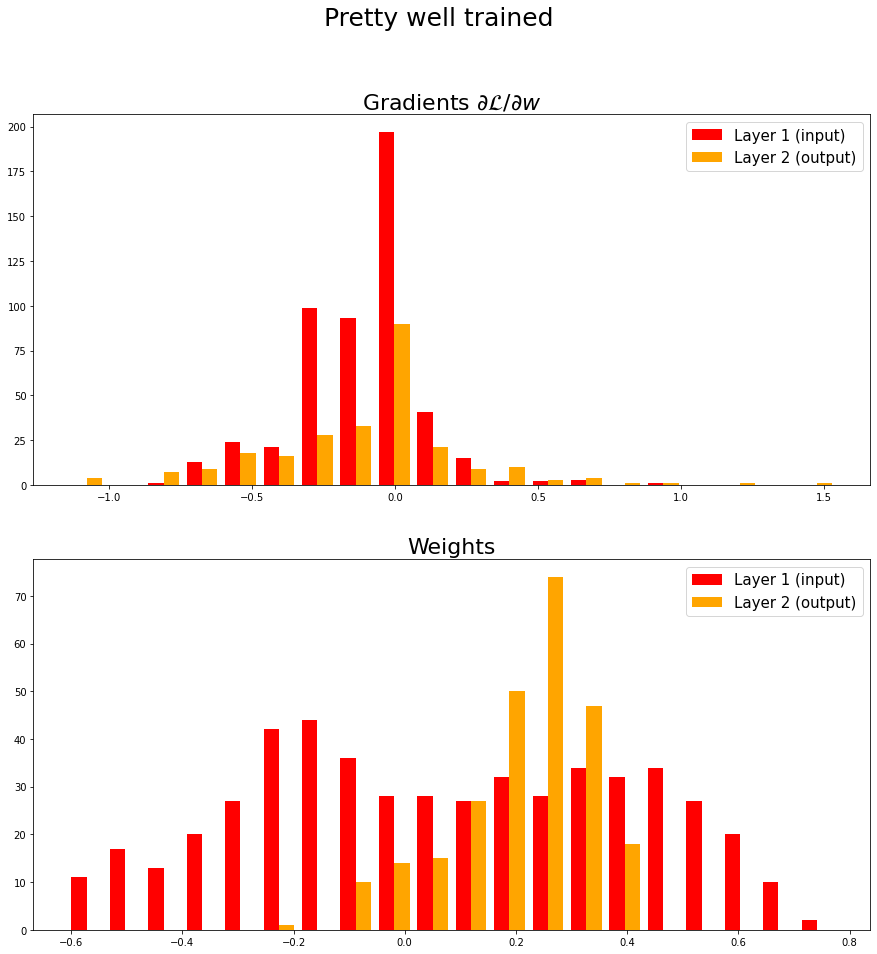

In [63]:
k = list(map(lambda x: x.grad, net.parameters()))
l = list(map(lambda x: x.data, net.parameters()))
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Pretty well trained', fontsize=25)

ax = plt.subplot(211)
plt.hist([
    k[0].cpu().numpy().reshape(-1),
    k[2].cpu().numpy().reshape(-1),
], bins=20, color=['r', 'orange'], label=['Layer 1 (input)', 'Layer 2 (output)'])
ax.set_title(r'Gradients $\partial \mathcal{L} / \partial w$', fontsize=22)
ax.legend(fontsize=15)

ax = plt.subplot(212)
plt.hist([
    l[0].cpu().numpy().reshape(-1),
    l[2].cpu().numpy().reshape(-1),
], bins=20, color=['r', 'orange'], label=['Layer 1 (input)', 'Layer 2 (output)'])
ax.set_title('Weights', fontsize=22)
ax.legend(fontsize=15)

plt.show()

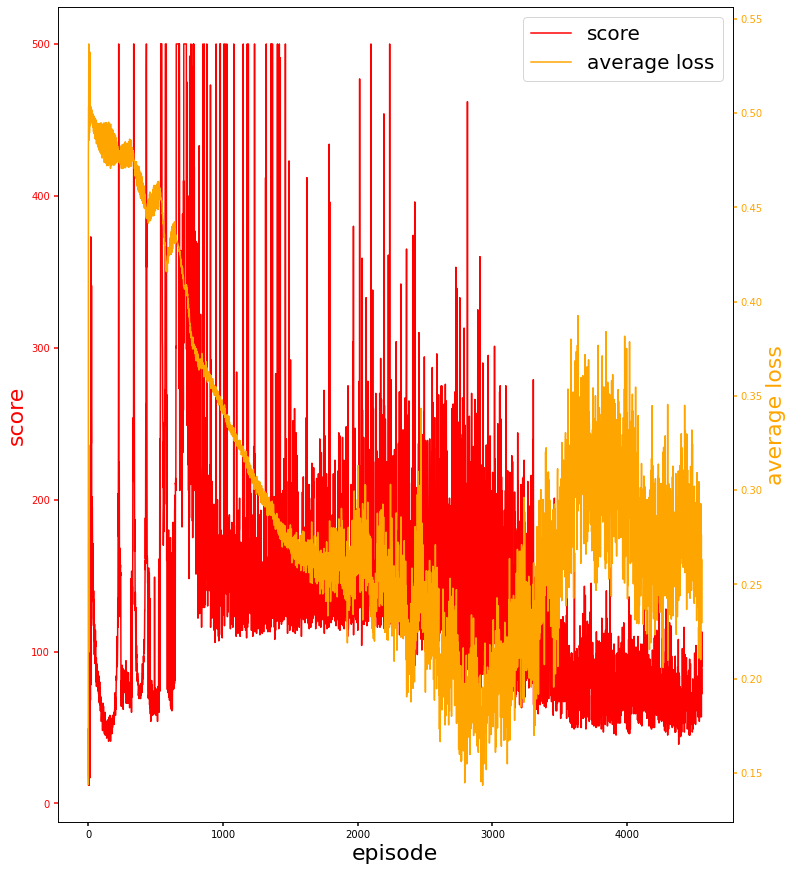

In [19]:
fig, host = plt.subplots()
fig.set_size_inches(15, 15)
fig.subplots_adjust(right=.75)

par1 = host.twinx()
# par2 = host.twinx()

# par2.spines['right'].set_position(('axes', 1.2))
# par2.spines['right'].set_visible(True)

p1, = host.plot(record['score'], 'r', label='score')
p2, = par1.plot(record['average loss'], 'orange', label='average loss')

host.set_xlabel('episode', fontsize=22)
host.set_ylabel('score', fontsize=22)
par1.set_ylabel('average loss', fontsize=22)

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', **tkw) 
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)

lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines], fontsize=20)  # 이렇게 안 하면 child에 그려진 애들은 legend가 안 붙나봄
plt.show() 